In [1]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
# Commented out because we yet again find mps to be drastically slower
# elif torch.backends.mps.is_available():
#     torch._dynamo.disable()  # https://github.com/pytorch/pytorch/issues/149184
#     device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"{device=}")

device=device(type='cpu')


In [2]:
from transformers import AutoTokenizer
from datasets import load_dataset

tokenizer = AutoTokenizer.from_pretrained("openai-community/gpt2")
dataset = load_dataset("wikitext", "wikitext-103-v1")

In [4]:
from pathlib import Path
from datasets import load_from_disk

context_length = 512

def tokenize(batch):
    # TODO: Sequence packing
    outputs = tokenizer(
        batch["text"],
        truncation=True,
        max_length=context_length,
        return_overflowing_tokens=True,
        return_length=True,
    )
    return {
        "input_ids": [
            input_ids
            for length, input_ids in zip(outputs["length"], outputs["input_ids"])
            if length == context_length
        ]
    }

if Path("tokenized-wiki-ds.hf").exists():
    tokenized_ds = load_from_disk("tokenized-wiki-ds.hf")
else:
    tokenized_ds = dataset.map(
        tokenize, batched=True, remove_columns=dataset["train"].column_names
    )
    tokenized_ds.save_to_disk("tokenized-wiki-ds.hf")
tokenized_ds

DatasetDict({
    test: Dataset({
        features: ['input_ids'],
        num_rows: 12746
    })
    train: Dataset({
        features: ['input_ids'],
        num_rows: 5333343
    })
    validation: Dataset({
        features: ['input_ids'],
        num_rows: 11174
    })
})

In [5]:
from torch import nn

class PositionalEmbedding(nn.Module):
    def __init__(self, embedding_dim, device):
        super().__init__()
        self.numerators = 10_000 ** (  # TODO: Why 10_000?
            torch.arange(
                start=0,
                end=embedding_dim,
                step=2,
                device=device,
            ).float()
            / embedding_dim
        )

    def forward(self, input_ids: torch.Tensor):
        with torch.no_grad():
            positions = torch.arange(
                input_ids.shape[1],
                device=input_ids.device,
            ).float()
            raw_embeddings = positions.unsqueeze(1) @ (1 / self.numerators).unsqueeze(0)
            even_embeddings = torch.sin(raw_embeddings)
            odd_embeddings = torch.cos(raw_embeddings)
            embeddings = torch.stack(
                [even_embeddings, odd_embeddings], dim=-1
            ).view(
                len(positions), -1
            )
            return embeddings.unsqueeze(0).expand(input_ids.shape[0], -1, -1)


token_embedder = nn.Embedding(
    num_embeddings=tokenizer.vocab_size, embedding_dim=512, device=device
)
positional_embedder = PositionalEmbedding(embedding_dim=512, device=device)
transformer_layer = nn.TransformerEncoderLayer(d_model=512, nhead=8, device=device)
transformer = nn.TransformerEncoder(transformer_layer, num_layers=6)
decoder = nn.Linear(512, tokenizer.vocab_size, device=device)

src = ["Hi, my name", "The United States of"]
tokenized = tokenizer(src, return_tensors="pt").to(device)
embedded = token_embedder(tokenized.input_ids) + positional_embedder(tokenized.input_ids)
transformed = transformer(
    embedded.permute(1, 0, 2),  # Transformer expects (seq_len, batch_size, features)
    mask=nn.Transformer.generate_square_subsequent_mask(tokenized.input_ids.shape[1], device=device),
    # Skipping is_causal since seems troublesome: https://github.com/pytorch/pytorch/issues/96941
)
logits = decoder(transformed.permute(1, 0, 2))  # Back to (batch_size, seq_len, features)
result = tokenizer.batch_decode(logits[:, -1, :].argmax(dim=-1))
result

/Users/jacob/repos/reimplementing/.pixi/envs/default/lib/python3.13/site-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


[' Theft', ' playable']

In [22]:
class MyGPT(nn.Module):
    def __init__(self, d_model, nhead, num_layers, dim_feedforward, device):
        super().__init__()
        self.device = device
        self.token_embedder = nn.Embedding(
            num_embeddings=tokenizer.vocab_size, embedding_dim=d_model, device=device
        )
        self.positional_embedder = PositionalEmbedding(embedding_dim=d_model, device=device)
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, device=device),
            num_layers=num_layers,
        )
        self.decoder = nn.Linear(d_model, tokenizer.vocab_size, device=device)

    def forward(self, input_ids: torch.Tensor):
        embedded = self.token_embedder(input_ids) + self.positional_embedder(input_ids)
        transformed = self.transformer(
            embedded.permute(1, 0, 2),  # Transformer expects (seq_len, batch_size, features)
            mask=nn.Transformer.generate_square_subsequent_mask(input_ids.shape[1], device=input_ids.device),
        )
        logits = self.decoder(transformed.permute(1, 0, 2))
        return logits
    
    def stream(self, input_ids: torch.Tensor, max_length=50):
        # TODO: KV-cache to avoid quadratic computational complexity in `max_length`
        output_ids = input_ids.clone()
        for _ in range(max_length):
            with torch.no_grad():
                logits = self(output_ids)
                # TODO: Support stochastic sampling
                next_token_id = logits[:, -1, :].argmax(dim=-1, keepdim=True)
                output_ids = torch.cat([output_ids, next_token_id], dim=1)
                yield next_token_id.item()
    
    def print_stream(self, tokenizer, prompt: str, max_length=50):
        print(prompt, end="", flush=True)
        input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to(device)
        for token in self.stream(input_ids, max_length=max_length):
            if token == tokenizer.eos_token_id:
                break
            print(tokenizer.decode(token), end="", flush=True)


model = MyGPT(d_model=512, nhead=8, num_layers=6, dim_feedforward=2048, device=device)
model

MyGPT(
  (token_embedder): Embedding(50257, 512)
  (positional_embedder): PositionalEmbedding()
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-5): 6 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (decoder): Linear(in_features=512, out_features=50257, bias=True)
)

In [23]:
tokenizer.batch_decode(model(tokenizer(src, return_tensors="pt").input_ids.to(device))[:, -1, :].argmax(dim=-1))

[' affordable', ' Harden']

In [26]:
for _ in range(10):
    model.print_stream(tokenizer=tokenizer, prompt="The United States of", max_length=50)
    print("", flush=True)

The United States of cruise Plan777 inducing cruise Plan LS cruise Plan LS cruise Plan LS 13 clutching brandeddecl Contrast LS 13 LS 13 LS�� LS 13 LS 13 asleep Casribut Suppose� quicker Polyribut ``��elfth drinkersryptedimmigrant 106Bot LS��Chapter branded 106Bot
The United States of cruise Plan cruise Plan LS deceased Corps deceased Corps cruiseAverage LIM 0000 clutchingRy LS 13 LS 13 LS�� LS 13 robbed assortment LS 13 entails................................................................ribut giveaway LS��catchACPChapter branded 106Botribut simul LSyre LS��Chapterribut Suppose 106 106
The United States of Lakes bigger cruise moth cer cruise Plan LS cruise Plan LS 13 0000 106 designsyre LS 13 LS 13nesia LS 13zunesia LS�� LS 13 giveaway LS 13 giveawayribut Suppose 106 simul 106Bot 106Bot 13 simul branded simul 13 asleep === 13 simul
The United States of stay cruise damaged disposed damaged Ninth cruise Plan LS cruise damaged quicker PolyguardsRy 106Ry LS cruiseyre LS `` 106 daemonRy L

In [30]:
dataset["train"]["text"][:5]

['',
 ' = Valkyria Chronicles III = \n',
 '',
 ' Senjō no Valkyria 3 : <unk> Chronicles ( Japanese : 戦場のヴァルキュリア3 , lit . Valkyria of the Battlefield 3 ) , commonly referred to as Valkyria Chronicles III outside Japan , is a tactical role @-@ playing video game developed by Sega and Media.Vision for the PlayStation Portable . Released in January 2011 in Japan , it is the third game in the Valkyria series . Employing the same fusion of tactical and real @-@ time gameplay as its predecessors , the story runs parallel to the first game and follows the " Nameless " , a penal military unit serving the nation of Gallia during the Second Europan War who perform secret black operations and are pitted against the Imperial unit " <unk> Raven " . \n',
 " The game began development in 2010 , carrying over a large portion of the work done on Valkyria Chronicles II . While it retained the standard features of the series , it also underwent multiple adjustments , such as making the game more forgiving

In [74]:
print(tokenizer.pad_token_id)
tokenized = [
    {
        "input_ids": tokenizer(s, return_tensors="pt").input_ids.flatten().tolist()
    }
    for s in ["Hi", "my name is", "What, my name is"]
]
print(tokenized)
tokenizer.pad(tokenized, return_tensors="pt")

50256
[{'input_ids': [17250]}, {'input_ids': [1820, 1438, 318]}, {'input_ids': [2061, 11, 616, 1438, 318]}]


{'input_ids': tensor([[17250, 50256, 50256, 50256, 50256],
        [ 1820,  1438,   318, 50256, 50256],
        [ 2061,    11,   616,  1438,   318]]), 'attention_mask': tensor([[1, 0, 0, 0, 0],
        [1, 1, 1, 0, 0],
        [1, 1, 1, 1, 1]])}

In [86]:
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import LinearLR, CosineAnnealingLR, SequentialLR
from tqdm import tqdm

# All hyperparams in this cell were copied from GPT paper (although we use a different dataset)
model = MyGPT(d_model=768, nhead=12, num_layers=12, dim_feedforward=3072, device=device)

train_batch_size = 64
tokenizer.pad_token = tokenizer.eos_token
train_dl = DataLoader(
    tokenized_ds["train"],
    batch_size=train_batch_size,
    shuffle=True,
    collate_fn=lambda x: tokenizer.pad(x, return_tensors="pt"),
)
validation_dl = DataLoader(
    tokenized_ds["validation"],
    batch_size=train_batch_size * 2,
    shuffle=False,
    collate_fn=lambda x: tokenizer.pad(x, return_tensors="pt"),
)

optimizer = torch.optim.Adam(
    params=model.parameters(),
    betas=(0.9, 0.98),
    eps=1e-9,
    lr=2.5e-4,
)

num_epochs = 100
warmup_steps = 2000
total_steps = num_epochs * len(train_dl)
decay_steps = total_steps - warmup_steps
scheduler = SequentialLR(
    optimizer=optimizer,
    schedulers=[
        LinearLR(optimizer, start_factor=0.0, end_factor=1.0, total_iters=warmup_steps),
        CosineAnnealingLR(optimizer, T_max=decay_steps, eta_min=0.0),
    ],
    milestones=[warmup_steps],
)

log_frequency = 25
stream_frequency = 100
eval_frequency = 250

model.train()
train_losses = []
eval_losses = []
for epoch_i in range(num_epochs):
    for batch_i, batch in enumerate(train_dl):
        X: torch.Tensor = batch.input_ids.to(device)[:, :-1].contiguous()
        y: torch.Tensor = batch.input_ids.to(device)[:, 1:].contiguous()
        logits = model(X)
        loss = nn.functional.cross_entropy(
            logits.view(-1, logits.shape[-1]),
            y.view(-1),
            ignore_index=tokenizer.pad_token_id,
        )
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        scheduler.step()
        
        if batch_i % log_frequency == 0:
            train_losses.append(loss.item())
            print(f"Batch {batch_i + 1}/{len(train_dl)} in epoch {epoch_i + 1}/{num_epochs}: Loss {loss.item()}")
        
        if batch_i % stream_frequency == 0:
            model.eval()
            model.print_stream(tokenizer=tokenizer, prompt="The United States of", max_length=50)
            print("", flush=True)
            model.train()
        
        if batch_i % eval_frequency == 0:
            with torch.no_grad():
                model.eval()
                avg_val_loss = 0.0
                for validation_batch in validation_dl:
                    X_val: torch.Tensor = validation_batch.input_ids.to(device)[:, :-1].contiguous()
                    y_val: torch.Tensor = validation_batch.input_ids.to(device)[:, 1:].contiguous()
                    val_logits = model(X_val)
                    avg_val_loss += nn.functional.cross_entropy(
                        val_logits.view(-1, val_logits.shape[-1]),
                        y_val.view(-1),
                        ignore_index=tokenizer.pad_token_id,
                    ) / len(validation_dl)
                eval_losses.append(avg_val_loss.item())
                print(f"Avg. validation Loss {avg_val_loss.item()}")
                model.train()
    print("=" * 40 + f"COMPLETED EPOCH {epoch_i + 1}/{num_epochs}" + "=" * 40)

Batch 0: Loss 8.02338981628418
The United States of the the the of the the the the , the the the and of the the of of the of the , the in the the the the the of of the of of the the the of a the the the of the the the of , the of
Avg. validation Loss 7.778955459594727
Batch 25: Loss 7.6177825927734375
Batch 50: Loss 7.6399431228637695
Batch 75: Loss 7.591217994689941
Batch 100: Loss 7.5411601066589355
The United States of the the the the the the the the the the the , the the the the the the the , the the the the the the the the the the the the the the the , the the the the the the the the the the the the the the
Batch 125: Loss 7.607595920562744
Batch 150: Loss 7.460780143737793
Batch 175: Loss 7.595716953277588
Batch 200: Loss 7.465490818023682
The United States of the the the the the the the the the , the the the the the the the the the the the the , the the the the the the the the the , the the the the the , the the the , the the the the the the the
Batch 225: Loss 7.556653499603271

KeyboardInterrupt: 

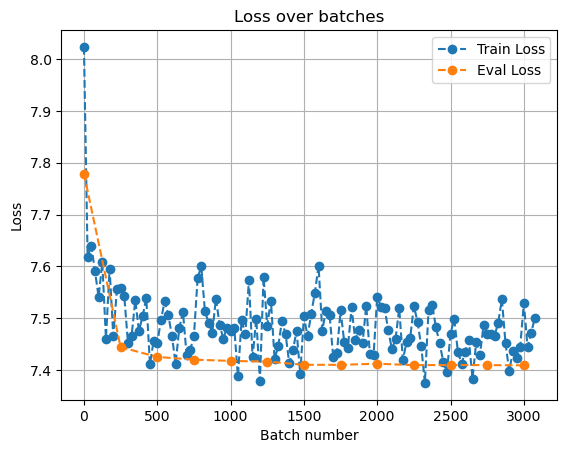

In [87]:
import numpy as np
import matplotlib.pyplot as plt

train_loss_batch_i = np.arange(len(train_losses)) * log_frequency
eval_loss_batch_i = np.arange(len(eval_losses)) * eval_frequency
plt.plot(train_loss_batch_i, train_losses, "--o", label="Train Loss")
plt.plot(eval_loss_batch_i, eval_losses, "--o", label="Eval Loss")
plt.xlabel("Batch number")
plt.ylabel("Loss")
plt.title("Loss over batches")
plt.legend()
plt.grid()
plt.show()